In [1]:
%%capture
BASEPATH = '../'
import sys
sys.path.insert(0,'..')

import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pyecg.utils import reset_seed, plot_spectogram, plot_loss, load_data
from pyecg.utils import integer_mapping, mapping_AAMI, calc_class_weights
from pyecg.data_info import *
from pyecg.data_preprocessing import clean_inf_nan,clean_IQR,clean_IQR_class
from pyecg.data_handling import DataHandling,slice_data
from pyecg.report import Reports
from pyecg.utils import sig_similarity_report,sig_similarity_hist



reset_seed() 

2022-06-02 20:26:41.529507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-02 20:26:41.529546: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-02 20:26:52.377247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-02 20:26:52.377289: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-02 20:26:52.377336: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-06-02 20:26:52.377627: I tensorflow/core/platform/cpu_feature_gua

# Proto

In [2]:
datasets = {1:'raw',2:'stft',3:'raw_arr'}
models = {1:'conv1d', 2:'conv2d', 3:'anomaly_fcn',4:'anomaly_conv1d',5:'anomaly_conv2d',6:'beat_model'}

CONFIG = {}
CONFIG['dataset'] = datasets[1]
CONFIG['model'] = models[6]
CONFIG['model_type'] = 'CLF' #CLF or AE
CONFIG['augment'] = False 
CONFIG['sliced_targets'] = {'N':0,'A':1,'V':2} #None  #{'N':0,'A':1}
CONFIG['AAMI'] = False 
CONFIG['class_weight'] = False 
CONFIG['normalization'] = 'zscore'       #'zscore' 'minmax' , None, 'max' 

# Data

In [76]:
#Load data
dh = DataHandling(base_path='../data')

if CONFIG['dataset'] == 'raw':
    ds_train = dh.load_data(file_name = 'train.beat')
    x_train, r_train, y_train = ds_train.values()
    
    ds_val = dh.load_data(file_name = 'val.beat')
    x_val, r_val, y_val = ds_val.values()

elif CONFIG['dataset'] == 'stft':
    ds_train = dh.load_data(file_path = '../data/DS1_train_stft.dat')
    x_train, y_train, r_train = ds_train.values()
    ds_val = load_data(file_path = '../data/DS1_val_stft.dat')
    x_val, y_val, r_val = ds_val.values()
    
elif CONFIG['dataset'] == 'raw_arr':
    annotated_records, samples_info = load_data(file_path = '../data/DS1_samples.arr')
    
#x_train.shape, len(y_train), r_train.shape,len(y_val)

file loaded: ../data/train.beat
shape of "waveforms" is (27090, 800)
shape of "beat_feats" is (27090, 2)
shape of "labels" is (27090,)
                N     L     R   j   e     V    E    A  S   a   J    F  f  /  Q
train.beat  20200  1457  1592  14  16  2482  105  684  2  98  30  404  0  0  6
file loaded: ../data/val.beat
shape of "waveforms" is (23491, 800)
shape of "beat_feats" is (23491, 2)
shape of "labels" is (23491,)
              N     L     R  j  e     V  E    A  S  a  J  F  f  /  Q
val.beat  17562  2473  2149  1  0  1181  0  113  0  0  2  8  0  0  2


In [77]:
ds_train = clean_inf_nan(ds_train)
x_train, r_train, y_train = ds_train.values()

In [78]:
xx =  x_train.flatten()
max(xx),min(xx),sum(xx)/len(xx) 

(3.0571681682263936, -3.531306100843774, 0.05353817446333654)

In [79]:
rr =  r_train.flatten()
max(rr),min(rr),sum(rr)/len(rr) 

(84.32786885245812, 0.2768924302789901, 1.0125611883700758)

<AxesSubplot:>

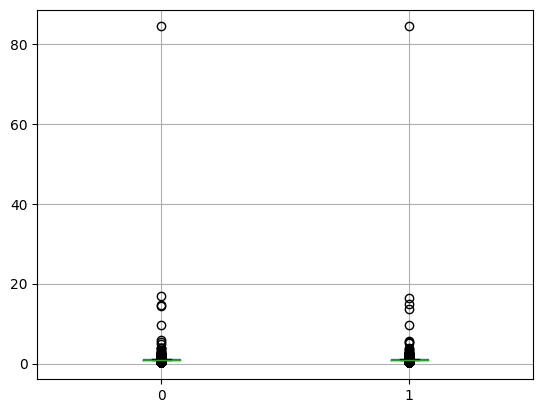

In [80]:
r_train.shape
pd.DataFrame(r_train).boxplot()

In [81]:
list(np.unique(y_train))

['A', 'E', 'F', 'J', 'L', 'N', 'Q', 'R', 'S', 'V', 'a', 'e', 'j']

In [82]:
#cleaning
ds_train = clean_IQR_class(ds_train,factor=1.9)

In [83]:
x_train, r_train, y_train = ds_train.values()
r_train.shape

(22077, 2)

<AxesSubplot:>

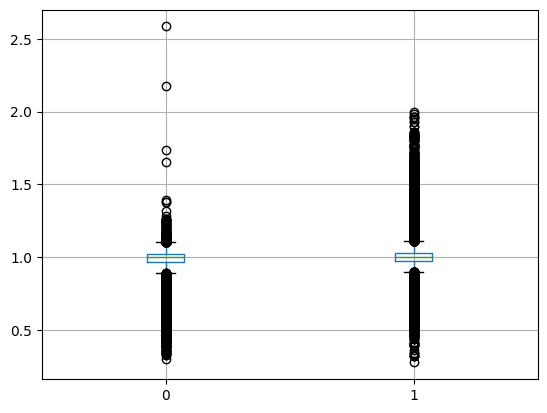

In [84]:
pd.DataFrame(r_train).boxplot()

In [85]:
rr =  r_train.flatten()
max(rr),min(rr),sum(rr)/len(rr) 

(2.5839416058394966, 0.2768924302789901, 0.9966791943172087)

In [86]:
ix = dh.search_label(ds_train,'N')

In [87]:
rp1 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp1 

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
train,15461,1425,1465,12,14,2458,94,630,2,94,26,392,0,0,4
val,17562,2473,2149,1,0,1181,0,113,0,0,2,8,0,0,2


In [88]:
#slice data
if CONFIG['sliced_targets'] is not None:
    from pyecg.data_handling import slice_data
    sliced_targets = CONFIG['sliced_targets']
    ds_train = slice_data(ds_train, sliced_targets)
    x_train, r_train, y_train = ds_train.values()
    ds_val = slice_data(ds_val, sliced_targets)
    x_val, r_val, y_val = ds_val.values()
    rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
    print(rp2)

           N  L  R  j  e     V  E    A  S  a  J  F  f  /  Q
train  15461  0  0  0  0  2458  0  630  0  0  0  0  0  0  0
val    17562  0  0  0  0  1181  0  113  0  0  0  0  0  0  0


In [89]:
#Normalization
if CONFIG['normalization'] == 'zscore':
    from sklearn.preprocessing import StandardScaler
    standardscaler_x = StandardScaler()
    x_train = standardscaler_x.fit_transform(x_train)
    x_val = standardscaler_x.transform(x_val) 
    
    standardscaler_r = StandardScaler()
    r_train = standardscaler_r.fit_transform(r_train)
    r_val = standardscaler_r.transform(r_val) 

if CONFIG['normalization'] == 'minmax':
    from sklearn.preprocessing import MinMaxScaler
    scaler_x = MinMaxScaler(feature_range=(-1,1)) 
    if len(x_train[0].shape)==1:
        x_train = scaler_x.fit_transform(x_train)
        x_val = scaler_x.transform(x_val)
    elif len(x_train[0].shape)==2:
        org_shape = x_train.shape
        x_train = scaler_x.fit_transform(x_train.reshape((-1,1)))
        x_train = x_train.reshape(org_shape)
        org_shape = x_val.shape
        x_val = scaler_x.transform(x_val.reshape((-1,1)))
        x_val = x_val.reshape(org_shape)

    scaler_r = MinMaxScaler(feature_range=(-1,1))
    r_train = scaler_r.fit_transform(r_train)
    r_val = scaler_r.transform(r_val)   

if CONFIG['normalization'] == 'max':   
    max_x_train = max(x_train.flatten())
    x_train = x_train/max_x_train
    x_val = x_val/max_x_train

xx =  x_train.flatten()
max(xx),min(xx),sum(xx)/len(xx)

(25.89501641092118, -19.31897968231408, 9.433638199951033e-16)

In [90]:
rr =  r_train.flatten()
max(rr),min(rr),sum(rr)/len(rr) 

(7.931465198242735, -6.303113456941081, 1.557484321636121e-14)

<AxesSubplot:>

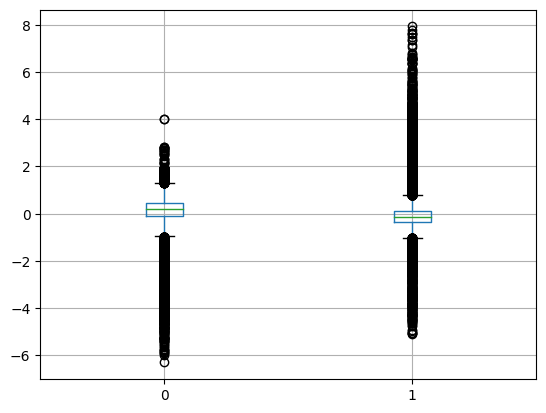

In [91]:
#normalized
pd.DataFrame(r_train).boxplot()

In [92]:
if CONFIG['AAMI']:
    y_train = mapping_AAMI(y_train, MAP_AAMI)
    y_val = mapping_AAMI(y_val, MAP_AAMI)

In [93]:
rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
print(rp2) 

           N  L  R  j  e     V  E    A  S  a  J  F  f  /  Q
train  15461  0  0  0  0  2458  0  630  0  0  0  0  0  0  0
val    17562  0  0  0  0  1181  0  113  0  0  0  0  0  0  0


In [94]:
#augment
if CONFIG['augment']==True:
    from pyecg.data_augmentation import aug_decrease,aug_increase
    ds_train = aug_decrease(ds_train, label='N', desired_size = 12000)
    ds_train = aug_increase(ds_train, desired_size = 12000)
    x_train, r_train, y_train = ds_train.values()
    
rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
print(rp2)

           N  L  R  j  e     V  E    A  S  a  J  F  f  /  Q
train  15461  0  0  0  0  2458  0  630  0  0  0  0  0  0  0
val    17562  0  0  0  0  1181  0  113  0  0  0  0  0  0  0


In [73]:
#convert labels to integers
targets = np.unique(y_train).tolist()
FINAL_MAP_DICT = {targets[i]:i for i in range(len(targets))}


y_train = integer_mapping(y_train, FINAL_MAP_DICT)
y_val = integer_mapping(y_val, FINAL_MAP_DICT)

In [95]:
np.unique(y_train), r_train.shape

(array(['A', 'N', 'V'], dtype='<U1'), (18549, 2))

In [75]:
#FINAL_MAP_DICT

# Train

In [23]:
if CONFIG['model'] == 'conv2d':
    from pyecg.models.conv2d_rr import model_arch
elif CONFIG['model'] == 'conv1d':
    from pyecg.models.conv1d_rr_paral import model_arch
elif CONFIG['model'] == 'anomaly_fcn':
    from pyecg.models.anomaly_FCN import model_arch
elif CONFIG['model'] == 'anomaly_conv1d':
    from pyecg.models.anomaly_conv1d import model_arch
elif CONFIG['model'] == 'anomaly_conv2d':
    from pyecg.models.anomaly_conv2d import model_arch
elif CONFIG['model'] == 'beat_model':
    from pyecg.models.beat_model import model_arch

In [44]:
params_model = {
    'x_input_dim' : np.squeeze(x_train[0].shape),
    'r_input_dim':r_train.shape[-1],
    'num_classes' : len(np.unique(y_train)),
    'dim_latent' : 10,
    'regularizer' : None
}
params_train = {
    'batch_size' : 128,
    'epochs' : 5
} 

In [26]:
mymodel = model_arch(params_model)   
mymodel.summary()

Model: "Model_Beat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 r_input (InputLayer)           [(None, 145)]        0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 145, 1)       0           ['r_input[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 145, 1)      4           ['tf.expand_dims[0][0]']         
 alization)                                                                                       
                                                                                                  
 flatten (Flatten)              (None, 145)          0           ['batch_normalization[0]

In [27]:
#%%capture
#!pip install focal-loss
#from focal_loss import SparseCategoricalFocalLoss

In [28]:
def my_log_loss(y_true, y_pred):
    squared_difference = tf.square(tf.math.log(y_true + 5) - tf.math.log(y_pred + 5))
    return tf.reduce_mean(squared_difference, axis=-1) 

In [29]:
!rm -r /media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1

opt= tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam')
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

def get_loss(model_type):
    if model_type == 'AE':
        loss = "mse"
        #loss = 'binary_crossentropy'
        #loss='mean_squared_logarithmic_error'
        #loss = my_log_loss
        #loss = 'cosine_similarity'
    elif model_type == 'CLF':
        loss = "sparse_categorical_crossentropy"
        #loss=SparseCategoricalFocalLoss(gamma=3)
    return loss

def get_metrics(model_type):
    if model_type == 'AE':
        metrics = None
    elif model_type == 'CLF':
        metrics = ['accuracy']
    return metrics
    

mymodel.compile(
              optimizer = opt,
              loss = get_loss(CONFIG['model_type']),
              metrics = get_metrics(CONFIG['model_type']),
              loss_weights = None
              )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5,
                              verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(BASEPATH + "checkpoint/keras.EXP1",
                                                      monitor='val_loss', save_best_only=True, verbose=1)
import time
batch_sleep = tf.keras.callbacks.LambdaCallback(on_batch_end=lambda batch,logs: time.sleep(.3))

callbacks = [early_stopping, model_checkpoint, reduce_lr, batch_sleep]  
#callbacks = [batch_sleep]  

In [30]:
calc_class_weights(CONFIG['class_weight'], y_train)

In [31]:
#model output
if CONFIG['model_type'] == 'AE':
    output_shape = mymodel.output_shape
    if isinstance(output_shape,list) and len(output_shape) == 2:
        y_train_ = [x_train,r_train]
        y_val_ = [x_val,r_val]   
    elif not isinstance(output_shape,list):
        y_train_ = x_train
        y_val_ = x_val 
else:
    y_train_ = y_train 
    y_val_ = y_val 

#model input   
input_shape = mymodel.input_shape
if isinstance(input_shape,list) and len(input_shape) == 2:
    x_train_ = {'x_input':x_train, 'r_input':r_train}
    x_val_ = {'x_input':x_val, 'r_input':r_val}   
elif not isinstance(input_shape,list): 
    x_train_ = x_train
    x_val_ = x_val    
    

In [32]:
%%time

#model fitting
model_history = mymodel.fit(
              x=x_train_,
              y=y_train_,
              batch_size=params_train['batch_size'],
              epochs=params_train['epochs'],
              verbose=1,
              callbacks=callbacks,
              validation_data=(x_val_, y_val_),
              shuffle=True,
              class_weight= calc_class_weights(CONFIG['class_weight'], y_train),    #None,
              sample_weight=None,
              initial_epoch=0
              )

Epoch 1/5
31/31 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.9190
Epoch 1: val_loss improved from inf to 0.13234, saving model to ../checkpoint/keras.EXP1


2022-04-22 05:19:07.785142: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


31/31 [==============================] - 12s 362ms/step - loss: 0.2662 - accuracy: 0.9190 - val_loss: 0.1323 - val_accuracy: 0.9577 - lr: 0.0010
Epoch 2/5
31/31 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9951
Epoch 2: val_loss improved from 0.13234 to 0.06365, saving model to ../checkpoint/keras.EXP1
31/31 [==============================] - 12s 374ms/step - loss: 0.0177 - accuracy: 0.9951 - val_loss: 0.0637 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 3/5
31/31 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9979
Epoch 3: val_loss improved from 0.06365 to 0.06303, saving model to ../checkpoint/keras.EXP1
31/31 [==============================] - 11s 368ms/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.0630 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 4/5
31/31 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9990
Epoch 4: val_loss improved from 0.06303 to 0.05732, saving model to ../checkpoint/keras.EXP1
31/31 [

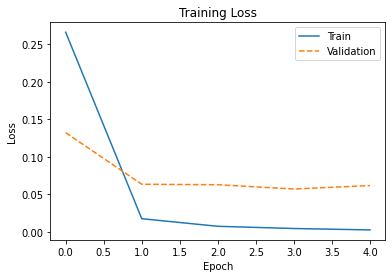

In [33]:
plot_loss(model_history) 

import pickle
with open(BASEPATH+'history/EXP1.hist', 'wb') as f:
  pickle.dump(model_history.history, f)

a =model_history.history
min(a['val_loss']), a['val_loss'].index(min(a['val_loss']))

# Loading Model

In [26]:
loaded_model = tf.keras.models.load_model(BASEPATH+'checkpoint/keras.EXP1')
#mymodel = tf.keras.models.load_model(BASEPATH+'saved_models/mymodel')
#loaded_model = mymodel
loaded_model.name
#loaded_model.summary()

'Model_Beat'

In [96]:
#Load Preprocessed Test Set
dh = DataHandling(base_path='../data')
if CONFIG['dataset'] == 'raw':
    ds_test = dh.load_data(file_name = 'test.beat')
    ds_test = clean_inf_nan(ds_test)
    x_test, r_test, y_test = ds_test.values()   
    
elif CONFIG['dataset'] == 'stft':
    ds_test = dh.load_data(file_name = 'DS2_stft.dat')
    x_test, y_test, r_test = ds_test.values() 

file loaded: ../data/test.beat
shape of "waveforms" is (49272, 800)
shape of "beat_feats" is (49272, 2)
shape of "labels" is (49272,)
               N     L     R    j  e     V  E     A  S   a   J    F  f  /  Q
test.beat  36118  4089  3441  213  0  3194  1  1720  0  50  51  388  0  0  7


In [97]:
#slice test data
if CONFIG['sliced_targets'] != None and params_model['num_classes']>1:
    from pyecg.data_handling import slice_data
    sliced_targets = CONFIG['sliced_targets']
    ds_test = slice_data(ds_test, sliced_targets)
    x_test, r_test, y_test = ds_test.values()

In [98]:
rp2 = dh.report_stats_table([y_test], ['test'])
rp2

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
test,36118,0,0,0,0,3194,0,1720,0,0,0,0,0,0,0


In [99]:
y_true = y_test.copy()

if CONFIG['AAMI']:
    y_true = mapping_AAMI(y_true, MAP_AAMI)

In [100]:
if CONFIG['normalization'] == 'zscore':
    x_test = standardscaler_x.transform(x_test) 
    r_test = standardscaler_r.transform(r_test) 

if CONFIG['normalization'] == 'minmax':
    x_test = scaler_x.transform(x_test)
    r_test = scaler_r.transform(r_test)
    
if CONFIG['normalization'] == 'max':   
    x_test = x_test/max_x_train

In [101]:
if isinstance(input_shape,list) and len(input_shape) == 2:
    x_test = {'x_input':x_test, 'r_input':r_test}
    

NameError: name 'input_shape' is not defined

In [102]:
%%time
y_pred_p = loaded_model.predict(x_test)
y_pred_p.shape

NameError: name 'loaded_model' is not defined

In [59]:
if CONFIG['model_type'] == 'CLF':
    y_pred = integer_mapping(list(y_pred_p.argmax(axis=-1)), FINAL_MAP_DICT, inverse=True)
    dh = DataHandling() 
    rp2 = dh.report_stats_table([y_pred, y_true], ['y_pred','y_true'])
    print(rp2)
    labels = [k for k,v in INT_MAP_DICT.items()]
    report = Reports(y_true=y_true, y_pred=y_pred, labels=labels)
    normalize = None
    #report.plot_confusion_matrix(normalize=normalize, values_format='')
    print(report.the_classification_report())
    #report.metrics_table() 
    from sklearn.metrics import confusion_matrix, classification_report
    print(confusion_matrix(y_true, y_pred)) 

            N  L  R  j  e     V  E     A  S  a  J  F  f  /  Q
y_pred  33849  0  0  0  0  6397  0   786  0  0  0  0  0  0  0
y_true  36118  0  0  0  0  3194  0  1720  0  0  0  0  0  0  0
              precision    recall  f1-score   support

           A     0.0840    0.0384    0.0527      1720
           N     0.9694    0.9085    0.9379     36118
           V     0.4787    0.9587    0.6385      3194

    accuracy                         0.8759     41032
   macro avg     0.5107    0.6352    0.5430     41032
weighted avg     0.8941    0.8759    0.8775     41032

[[   66   960   694]
 [  665 32812  2641]
 [   55    77  3062]]


In [43]:
pritndsafg()

NameError: name 'pritndsafg' is not defined

# ML classical (RF)

In [103]:
r_train.shape,y_train.shape,r_val.shape,y_val.shape

((18549, 2), (18549,), (18856, 2), (18856,))

In [131]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,
                             criterion='gini', #gini entropy
                             min_samples_split=2,
                             min_samples_leaf=2,
                             class_weight=None, #balanced_subsample balanced None
                             ccp_alpha=0.0,
                             bootstrap=True,
                             #max_samples=5000,
                             random_state=986,
                             warm_start=False,
                             n_jobs=-1)
clf.fit(r_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_jobs=-1, random_state=986)

In [132]:
y_true = y_test
y_pred = clf.predict(r_test)
#y_pred = integer_mapping(y_pred, FINAL_MAP_DICT, inverse=True)

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred)) 

              precision    recall  f1-score   support

           A       0.03      0.03      0.03      1720
           N       0.95      0.75      0.84     36118
           V       0.26      0.90      0.40      3194

    accuracy                           0.73     41032
   macro avg       0.41      0.56      0.42     41032
weighted avg       0.86      0.73      0.77     41032

[[   44  1096   580]
 [ 1117 27234  7767]
 [  114   212  2868]]


In [87]:
fi = clf.feature_importances_

In [88]:
finame=(
['ratio_pre_avg', 'ratio_post_avg'])

<BarContainer object of 2 artists>

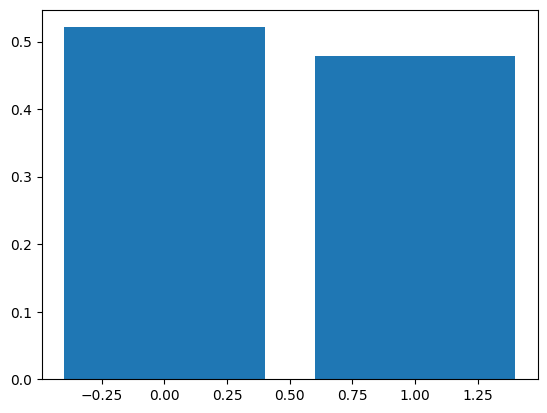

In [89]:
plt.bar(range(len(fi)),fi)

In [90]:
pd.DataFrame(zip(finame,fi),columns=['Feat','FI']).sort_values(by='FI',ascending=False).head(30)

,Feat,FI
0,ratio_pre_avg,0.521202
1,ratio_post_avg,0.478798


# ML classical (XGB)

In [95]:
r_train.shape,y_train.shape,r_val.shape,y_val.shape

((18549, 2), (18549,), (18856, 2), (18856,))

In [96]:
from xgboost import XGBClassifier
xgbclf = XGBClassifier(n_estimators=1000)
xgbclf.fit(r_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [97]:
y_true = y_test
y_pred = xgbclf.predict(r_test)
y_pred = integer_mapping(y_pred, FINAL_MAP_DICT, inverse=True)

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           A       0.04      0.04      0.04      1720
           N       0.95      0.75      0.84     36118
           V       0.26      0.88      0.40      3194

    accuracy                           0.73     41032
   macro avg       0.42      0.56      0.43     41032
weighted avg       0.86      0.73      0.77     41032

[[   76  1072   572]
 [ 1707 27058  7353]
 [  169   210  2815]]


In [ ]:
pikfgjk()

In [ ]:
if CONFIG['model_type'] == 'AE':
    sig_similarity_report(x_test,y_pred_p,y_test)

In [ ]:
if CONFIG['dataset'] == 'stft':
    ind = dh.search_type(y_true, sym='N')

    n = 9

    fig, (ax1, ax2) = plt.subplots(1, 2)
    #fig.suptitle('#:{} class:{} '.format(n,sym))
    ax1.imshow(x_test[ind[n]].T)
    ax2.imshow(np.squeeze(y_pred_p[ind[n]]).T)
    ax1.invert_yaxis() 
    ax2.invert_yaxis() 

In [ ]:
ind = dh.search_label(y_true, sym='N')
import matplotlib.pyplot as plt
n = 2000
plt.plot(x_test[ind[n]])
plt.plot(y_pred_p[ind[n]]) 

In [ ]:
output_shape = mymodel.output_shape
if isinstance(output_shape,list) and len(output_shape) == 2:
    mse = []
    syms = []
    for s in np.unique(y_true):
        ind = dh.search_type(y_true, sym=s)
        err = np.mean(np.square(r_test[ind] - y_pred_p[1][ind]))
        mse.append(err)
        syms.append(s)
        
    dict_res_r = {'sym':syms, 'mse_r':mse}
    df_r = pd.DataFrame(dict_res_r)
    print(df_r.sort_values(by='mse_r')) 
    
    ind = dh.search_type(y_true, sym='A')
    n = 100
    plt.plot(r_test[ind[n]])
    plt.plot(y_pred_p[1][ind[n]]) 
    
    df = pd.concat([df_x,df_r['mse_r']],axis=1)
    df['mse_sum'] = df[['mse_x','mse_r']].sum(axis=1)
    df.sort_values(by='mse_sum') 

In [ ]:
#fake signal
in_array = np.linspace(-2*np.pi, 2*np.pi, 220)
out_array = -1*np.sin(in_array)+np.sin(3*in_array)
out_array = out_array.reshape(1,-1)
out_array += 0.2*np.random.rand(1,220)

y_pred = loaded_model.predict(out_array)

plt.plot(out_array[0])
plt.plot(y_pred[0])


from sklearn.metrics import mean_squared_error
cosine_similarity = tf.keras.metrics.CosineSimilarity(axis=-1)
from fastdtw import fastdtw
from pyecg.utils import normalized_cross_corr

print(np.mean(np.square(out_array.flatten() - y_pred.flatten())))
print(cosine_similarity(out_array, y_pred).numpy())
print(fastdtw(out_array,y_pred)[0])
print(normalized_cross_corr(out_array[0],y_pred[0]))

# Latent

In [ ]:
ds_train = load_data(file_path = '../data/DS1_train.dat')
x_train, y_train, r_train = ds_train.values() 

In [ ]:
from pyecg.data_handling import slice_data
ds_train = slice_data(ds_train, ['N']) 
x_train, y_train, r_train = ds_train.values()

In [ ]:
ds_train = clean_inf_nan(ds_train)
x_train, y_train, r_train = ds_train.values()

In [ ]:
plt.plot(r_train[:,1])

In [ ]:
x_train.shape,r_train.shape,len(y_train)

In [ ]:
ds_train = clean_IQR(ds_train)
x_train, y_train, r_train = ds_train.values()
x_train.shape,r_train.shape,len(y_train) 

In [ ]:
hh=plt.hist(r_train[:,70],bins=100) 

In [ ]:
min(r_train[:,70]),max(r_train[:,70])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_r = MinMaxScaler(feature_range=(0,1))
r_train = scaler_r.fit_transform(r_train)
r_test = scaler_r.transform(r_test)  

In [ ]:
from sklearn.preprocessing import StandardScaler
standardscaler_r = StandardScaler()
r_train = standardscaler_r.fit_transform(r_train)
r_test = standardscaler_r.transform(r_test) 

In [ ]:
max(r_train.flatten()),max(r_test.flatten())

In [ ]:
x = x_train
r = r_train
y = y_train


encoder = tf.keras.Model(mymodel.input, mymodel.get_layer('latent').output)
x_lat_train = encoder.predict(x) 

In [ ]:
x_lat_train[10]

In [ ]:
%%time

new_x = np.concatenate((x_lat_train, r_train), axis=-1)
#new_x = r_train
print('shape of new_x: '+str(new_x.shape))


ind = dh.search_type(y_train, sym='N')
new_x_train = new_x[ind] 
print('shape of new_x: '+str(new_x_train.shape))


params_model = {
    'x_input_dim' : np.squeeze(new_x_train[0].shape),
    'r_input_dim':r_train.shape[-1],
    'num_classes' : len(np.unique(y_train)),
    'dim_latent' : 4,
    'regularizer' : None
}

mymodel2 = model_arch(params_model)                                          

mymodel2.compile(
              optimizer = opt,
              loss = get_loss(CONFIG['model_type']),
              metrics = get_metrics(CONFIG['model_type']),
              loss_weights = None
              )

model_history2 = mymodel2.fit(
              x = new_x_train,
              y = new_x_train,
              batch_size = params_train['batch_size'],
              epochs=5,
              verbose=1,
              callbacks=callbacks,
              #validation_data=({'x_input':x_val, 'r_input':r_val}, y_val_),
              shuffle=True,
              #class_weight= calc_class_weights(CONFIG['class_weight'], y_train),    #None,
              sample_weight=None,
              initial_epoch=0
              ) 

In [ ]:
mymodel2.summary()

In [ ]:
#on train set
import matplotlib.pyplot as plt
n = 200
plt.plot(new_x_train[n])
new_pred_train = mymodel2.predict(new_x_train) 
plt.plot(new_pred_train[n]) 

In [ ]:
#save model
mymodel2.save(BASEPATH+'saved_models/mymodel2') 

In [ ]:
x = x_test
r = r_test
y = y_test

x_lat_test = encoder.predict(x)
new_x_test = np.concatenate((x_lat_test, r_test), axis=-1)
#new_x_test = r_test

new_pred_test = mymodel2.predict(new_x_test) 

In [ ]:
max(new_x_test.flatten())

In [ ]:
min(x_lat_train.flatten())

In [ ]:
#sig_similarity_report(new_x_test, new_pred_test, y_test) 

In [ ]:
#On test
ind = dh.search_type(y_test, sym='V')
import matplotlib.pyplot as plt
n = 200
plt.plot(new_x_test[ind[n]])
plt.plot(new_pred_test[ind[n]]) 

In [ ]:
df = sig_similarity_hist(new_x_test, new_pred_test, y_test) 
df.groupby('SYM').mean().sort_values(by='DTW')

In [ ]:
for sym in pd.unique(df['SYM']):
    ax = df[df['SYM']==sym].hist(column='DTW',bins=50, legend=True)
    ax[0][0].set_xlim(0,15)
    #ax[0][0].set_xticks(np.arange(0,15,1))
    plt.title(sym)
    

    
#df.hist(column='DTW',bins=30, legend=True)
    

In [ ]:
syms = pd.unique(df['SYM'])

fig, axes = plt.subplots(4,3, sharex=False, sharey=False)

for i in range(len(syms)): 
    y = i//3
    x = i % 3
    #print('({},{})'.format(y,x))
    ax = axes[y][x]
    ax.hist(df[df['SYM']==syms[i]],bins=40)
    ax.set_title(syms[i])


plt.show()

In [ ]:
x_lat = x_lat_test
y = y_test

#ind = dh.search_type(y, sym='j')
ind = list(np.arange(len(y)))

x_loc = x_lat[ind,0]
y_loc = x_lat[ind,1]
yy = [y[i] for i in ind]

labels = np.unique(y)
colors = np.arange(0,len(labels))
l_c_dict = dict(zip(labels,colors))
y_c = [l_c_dict[l] for l in yy] 

y_c
plt.figure(figsize=(6,6))
plt.scatter(x_loc,y_loc, s=.1, c=y_c)


In [ ]:
x_lat = x_lat_train
y = y_train

ind = dh.search_type(y, sym='j')
ind = list(np.arange(len(y)))

x_loc = x_lat[ind,0]
y_loc = x_lat[ind,1]
yy = [y[i] for i in ind]

labels = np.unique(y)
colors = np.arange(0,len(labels))
l_c_dict = dict(zip(labels,colors))
y_c = [l_c_dict[l] for l in yy]

y_c
plt.figure(figsize=(6,6))
plt.scatter(x_loc,y_loc, s=.1, c=y_c)


In [ ]:
latent_features.shape, r_train.shape, len(y_train)

In [ ]:
new_x.shape

In [ ]:
new_pred = mymodel2.predict([new_x, r_test])

In [ ]:
x = new_x
r = r_train
y = y_train

encoder2 = tf.keras.Model(mymodel2.input, mymodel2.get_layer('latent').output)
latent_features = encoder2.predict([x,r])

In [ ]:
latent_features[0] 

In [ ]:
ind = dh.search_type(y, sym='e')
ind = list(np.arange(len(y)))

x_loc = latent_features[ind,0]
y_loc = latent_features[ind,1]
yy = [y[i] for i in ind]
y_c = [l_c_dict[l] for l in yy]

y_c
plt.figure(figsize=(6,6))
plt.scatter(x_loc,y_loc, s=.1,alpha=.5, c=y_c)  

# Anomaly

In [ ]:
ds_train = load_data(file_path = '../data/DS1_train.dat')
ds_train = clean_inf_nan(ds_train)
x_train, y_train, r_train = ds_train.values()
#r_train = r_train[:,:]
r_train.shape

In [ ]:
syms = np.unique(y_train)

x_tt=[]
y_tt=[]
r_tt=[]
for sym in syms:
    ds_t = slice_data(ds_train, [sym])
    ds_t = clean_IQR(ds_t, factor=5.5)
    x_t, y_t, r_t = ds_t.values()
    x_tt.extend(list(x_t))
    y_tt.extend(list(y_t))
    r_tt.extend(list(r_t))
    
x_tt = np.array(x_tt)
r_tt = np.array(r_tt)    
ds_train = {'x':x_tt,'y':y_tt,'r':r_tt}


In [ ]:
len(x_tt),len(y_tt),len(r_tt)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_r = MinMaxScaler(feature_range=(-1,1))
r_train = scaler_r.fit_transform(r_train)
#r_test = scaler_r.transform(r_test)  

In [ ]:
from sklearn.preprocessing import StandardScaler
standardscaler_r = StandardScaler()
r_train = standardscaler_r.fit_transform(r_train)
#r_test = standardscaler_r.transform(r_test) 

In [ ]:
print('data shape:{}, min: {}, max: {}'.format(r_train.shape, min(r_train.flatten()), max(r_train.flatten())))

import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

X_train = r_train

#clf = IsolationForest(n_estimators=40,contamination=0.25, warm_start=True)
clf = OneClassSVM(gamma='auto', nu=0.25)
#clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.26)
clf.fit(X_train) 

In [ ]:
#predict
ds_test = clean_inf_nan(ds_test)
x_test, y_test, r_test = ds_test.values()

Y_TEST = y_train
X_TEST = r_train
pred_anomaly = clf.predict(X_TEST)
pred_anomaly.shape

In [ ]:
list(np.unique(Y_TEST))

In [ ]:
X_TEST.shape

In [ ]:
fig, axes = plt.subplots(5,3, sharex=True, sharey=False)

fig.set_figheight(15)
fig.set_figwidth(15)

syms = list(np.unique(Y_TEST))
pos=[]
neg=[]
for i in range(len(syms)): 
    y = i//3
    x = i % 3
    #print('({},{})'.format(y,x))
    ax = axes[y][x] 
    ind = dh.search_type(Y_TEST, sym=syms[i])
    pred_anomaly_c = pred_anomaly[ind] 
    #print(pred_anomaly_c.shape) 
    #hh=plt.hist(pred_anomaly_c,bins=3)
    aa=ax.hist(pred_anomaly_c,bins=2, density=True)
    if syms[i] !='N':
        pos.append(aa[0][1])
        neg.append(aa[0][0])
    else:
        pos.append(aa[0][0])
        neg.append(aa[0][1])        
    ax.set_title(syms[i]) 
print('score: '+str((sum(np.array(neg)-np.array(pos)))/len(pos)))
plt.show()

# Binary 

In [ ]:
ds_train = load_data(file_path = '../data/DS1_train.dat')
ds_train = clean_inf_nan(ds_train)
x_train, y_train, r_train = ds_train.values()
y_train = ['Normal' if item=='N' else 'Abnormal' for item in y_train]
#r_train = r_train[:,:] 
r_train.shape 

In [ ]:
%%time
from sklearn import svm
clf = svm.SVC(kernel='rbf',C=0.9)
clf.fit(r_train, y_train)

In [ ]:
#predict
ds_test = load_data(file_path = '../data/DS2.dat')
ds_test = clean_inf_nan(ds_test)
x_test, y_test, r_test = ds_test.values() 
y_test = ['Normal' if item=='N' else 'Abnormal' for item in y_test ]

on_test_set = True

Y_TEST = y_train
X_TEST = r_train
if on_test_set == True:
    Y_TEST = y_test
    X_TEST = r_test

y_pred = clf.predict(X_TEST)
y_pred.shape

In [ ]:
y_pred

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_pred,Y_TEST)

In [ ]:
print(classification_report(y_pred,Y_TEST))